In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from datetime import datetime

df=pd.read_csv('./result.csv')
df

,url,file_name,ID,date,decision,status,order,is_family,desc
0,www.uscis.gov/sites/default/files/err/D12%20-%...,SEP172020_01D12101.pdf,9044770,SEP172020,Appeal of Vermont Service Center Decision,"Form I-914, Application for T Nonimmigrant Status",The appeal is dismissed.,False,The Applicant seeks T-1 nonimmigrant classific...
1,www.uscis.gov/sites/default/files/err/D12%20-%...,SEP172020_02D12101.pdf,6288405,SEP172020,Appeal of Vermont Service Center Decision,"Form I-914, Application for T Nonimmigrant Status",The appeal is dismissed.,False,The Applicant seeks T-1 nonimmigrant classific...
2,www.uscis.gov/sites/default/files/err/D12%20-%...,SEP112020_01D12101.pdf,6500174,SEP112020,Appeal of Vermont Service Center Decision,"Form I-914, Application for Family Member of T...",The appeal is rejected.,True,The Applicant seeks nonimmigrant classificatio...
3,www.uscis.gov/sites/default/files/err/D12%20-%...,SEP092020_02D12101.pdf,6431583,SEP092020,Appeal of Vermont Service Center Decision,"Form I-914, Application for Family Member of T...",The appeal is rejected.,True,"the Applicant's Form 1-914, Application for T ..."
4,www.uscis.gov/sites/default/files/err/D12%20-%...,SEP092020_01D12101.pdf,6479121,SEP092020,Appeal of Vermont Service Center Decision,"Form I-914, Application for T Nonimmigrant Status",The decision of the Director is withdrawn.,False,The Applicant seeks T-1 nonimmigrant classific...
...,...,...,...,...,...,...,...,...,...
183,www.uscis.gov/sites/default/files/err/D12%20-%...,DEC282018_01D12101.pdf,1879191,DEC282018,APPEAL OF VERMONT SERVICE CENTER DECISION,"FORM I-914, APPLICATION FOR TNONlMMIGRANT STATUS",The appeal is dismissed.,False,The Applicant seeks T-1 nonimmigrant classific...
184,www.uscis.gov/sites/default/files/err/D12%20-%...,FEB232018_02D12101.pdf,884875,FEB232018,APPEAL OF VERMONT SERVICE CENTER DECISION,FORM I-914. SUPPLEMENT A. APPLICATION FOR IMME...,The appeal is dismissed.,True,"The Applicant, who seeks ""T -I"" nonimmigrant c..."
185,www.uscis.gov/sites/default/files/err/D12%20-%...,MAY012018_01D12101.pdf,1040935,MAY012018,APPEAL OF VERMONT SERVICE CENTER DECISION,"FORM I-914, APPLICATION FORT NONIMMIGRANT STATUS",The appeal is dismissed.,False,"The Applicant, a native and citizen of South K..."
186,www.uscis.gov/sites/default/files/err/D12%20-%...,FEB092018_02D12101.pdf,871867,FEB092018,APPEAL OF VERMONT SERVICE CENTER DECISION,"FORM I-914, APPLICATION FORT NONIMMIGRANT STATUS",The appeal is dismissed.,False,"The Applicant, a native and citizen of the Phi..."


In [24]:
mask_appeal=df.decision.map(lambda x:'appeal of' in x.lower())
mask_family=df.is_family==False
df_appeal_only=df[mask_appeal*mask_family]
df_appeal_only.order.value_counts()

The appeal is dismissed.                                                                                                                                  121
The decision of the Director is withdrawn.                                                                                                                 14
The appeal is sustained.                                                                                                                                    1
The matter is remanded for the entry of a new decision consistent with the foregoing analysis, which, if adverse, shall be certified to us for review.      1
The application is dismissed.                                                                                                                               1
The appeal is dismisse.                                                                                                                                     1
Name: order, dtype: int64

In [4]:
cate_dict={'granted':['grant','sustained','withdraw','remanded'],'dismissed':['dismiss']}
def order_fun(order):
    order=order.lower()
    for category in cate_dict:
        for kw in cate_dict[category]:
            if kw in order:
                return category
    return None

ser_order_category=df_appeal_only.order.map(order_fun)
ser_order_category.value_counts()


dismissed    123
granted       16
Name: order, dtype: int64

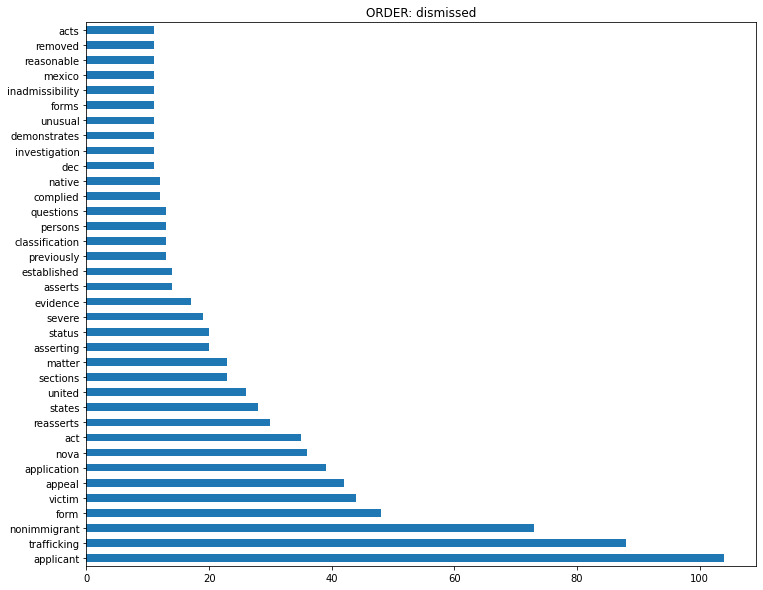

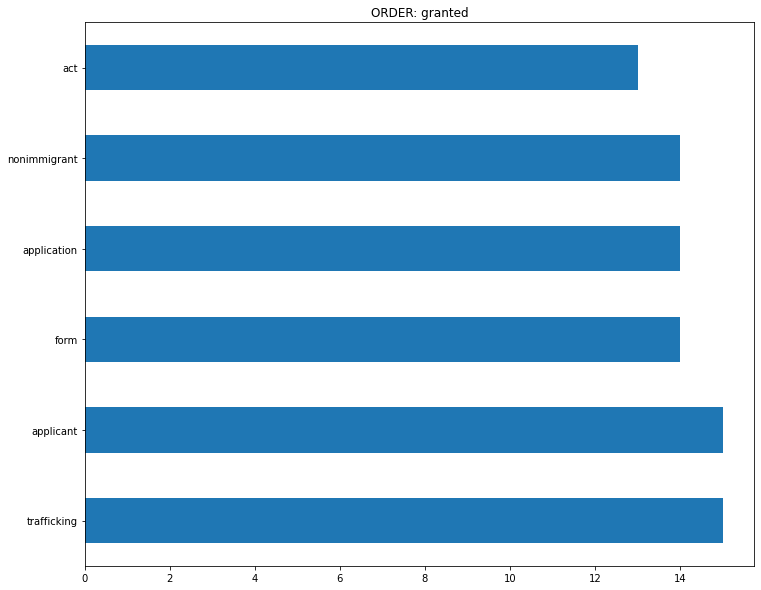

In [5]:
for CATEGORY in ['dismissed','granted']:
    documents =  df_appeal_only[ser_order_category==CATEGORY].desc
    vectorizer = TfidfVectorizer(token_pattern=r'\b[A-Za-z]{2,}\b',min_df=10,stop_words='english')
    X=vectorizer.fit_transform(documents).toarray()
    top10_tfidf_idxs=(-X).argsort(1)[:,:10].flatten()
    idx2word={v:k for k,v in vectorizer.vocabulary_.items()}
    top10_tfidf_words=[idx2word[i] for i in  top10_tfidf_idxs]
    ser_keyword=pd.Series(top10_tfidf_words).value_counts()
    ser_keyword[ser_keyword>10].plot(kind='barh',figsize=(12,10),title=f'ORDER: {CATEGORY}')
    plt.show()

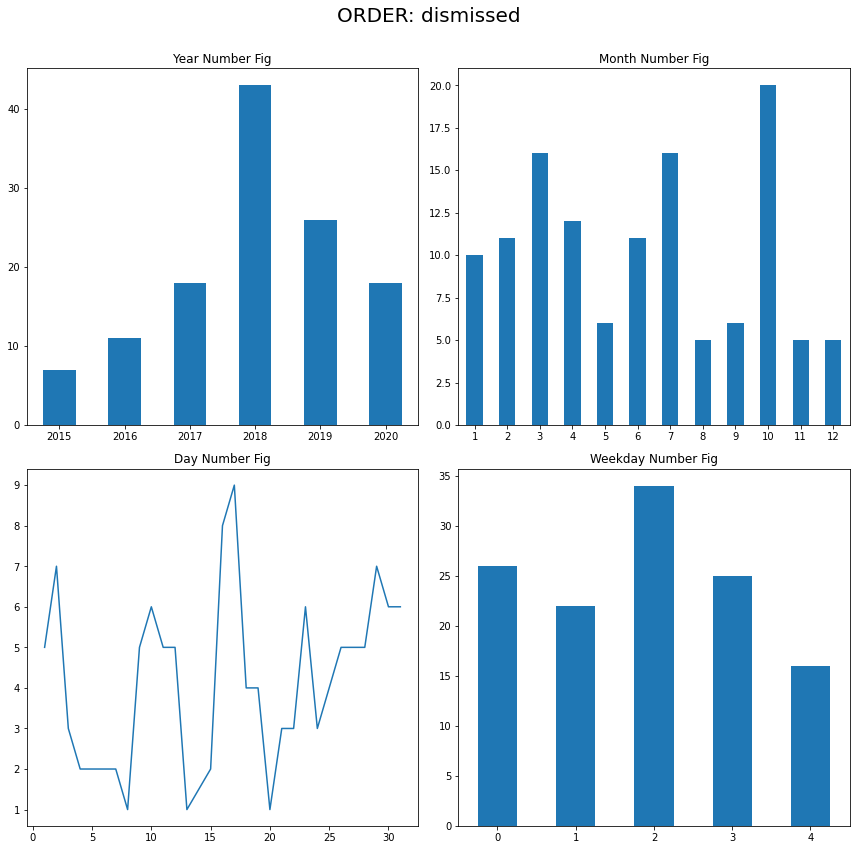

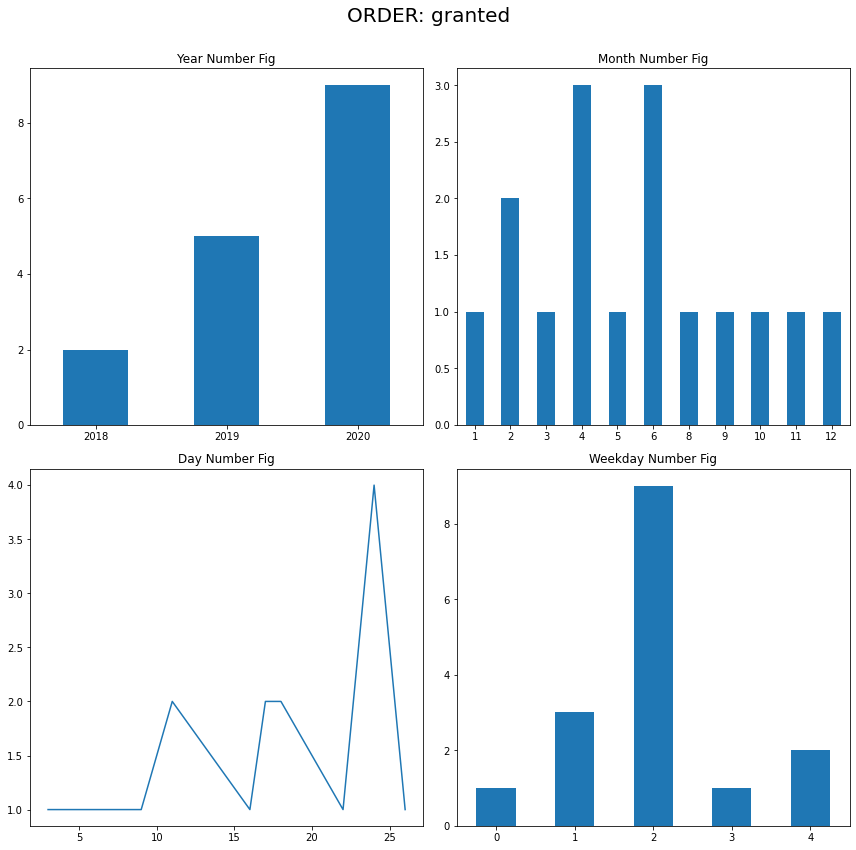

In [82]:
df_task4=df_appeal_only.copy()

def parse_date(dt_str):
    month_dict={'SEP':9, 'AUG':8, 'JUL':7, 'JUN':6, 'APR':4, 'MAR':3, 'FEB':2, 'JAN':1, 'DEC':12,
       'OCT':10, 'MAY':5, 'NOV':11}
    month=month_dict[dt_str[:3]]
    day=dt_str[3:5]
    year=dt_str[5:]
    return datetime.strptime(f'{year}-{month}-{day}','%Y-%m-%d')

df_task4['date']=df_task4['date'].map(parse_date)
for TYPE in ser_order_category.unique():
    df_tmp=df_task4[ser_order_category==TYPE]
    
    ser_year=df_tmp['date'].map(lambda x:x.year)
    ser_month=df_tmp['date'].map(lambda x:x.month)
    ser_day=df_tmp['date'].map(lambda x:x.day)
    ser_weekday=df_tmp['date'].map(lambda x:x.weekday())
    
    fig,axes=plt.subplots(2,2,figsize=(12,12))
    ser_year.value_counts().sort_index().plot(kind='bar',rot=0,title='Year Number Fig',ax=axes[0,0])
    ser_month.value_counts().sort_index().plot(kind='bar',rot=0,title='Month Number Fig',ax=axes[0,1])
    ser_day.value_counts().sort_index().plot(title='Day Number Fig',ax=axes[1,0])
    ser_weekday.value_counts().sort_index().plot(kind='bar',rot=0,title='Weekday Number Fig',ax=axes[1,1])
    plt.suptitle(f'ORDER: {TYPE}\n',fontsize=20)
    plt.tight_layout()
    plt.show()
